## Devoir IMN 

#### libraries

In [9]:
pip install torchvision

In [ ]:
pip install torch

### imports

In [48]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

### Reading data

In [26]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(56, 56)),
    transforms.ToTensor(),
])

# Load the datasets
train_dataset = datasets.ImageFolder("train/", transform=data_transforms)
test_dataset = datasets.ImageFolder("test/", transform=data_transforms)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)


len(test_dataset)/(len(train_dataset)+len(test_dataset))

0.28402964959568733

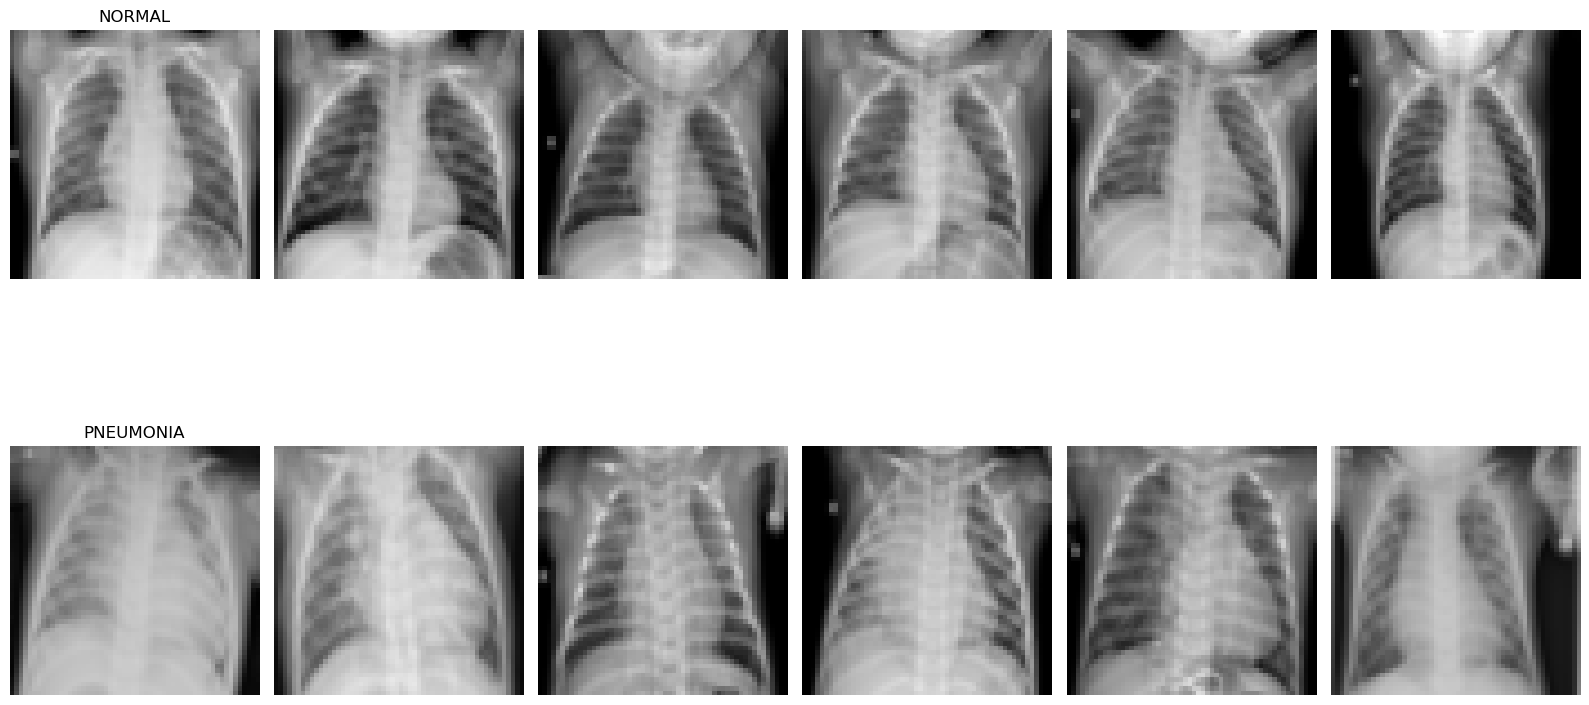

In [88]:
class_names = train_dataset.classes
class_counters = {class_name: 0 for class_name in class_names}
fig, axs = plt.subplots(nrows=len(class_names), ncols=6, figsize=(16, 10))
for image, label in train_dataset:
    class_name = class_names[label]
    if class_counters[class_name] >= 6:
        continue
    ax = axs[label, class_counters[class_name]]
    image_np = image.numpy().transpose((1, 2, 0))
    ax.imshow(image_np)
    ax.axis('off')
    class_counters[class_name] += 1
    if all(count >= 6 for count in class_counters.values()):
        break

for ax, class_name in zip(axs[:, 0], class_names):
    ax.set_title(class_name)
plt.tight_layout()
plt.show()

### Data Analyzing

[1069. 3181.]


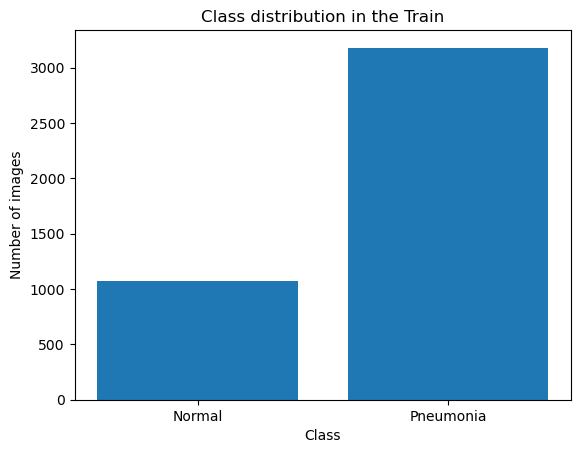

[ 594. 1092.]


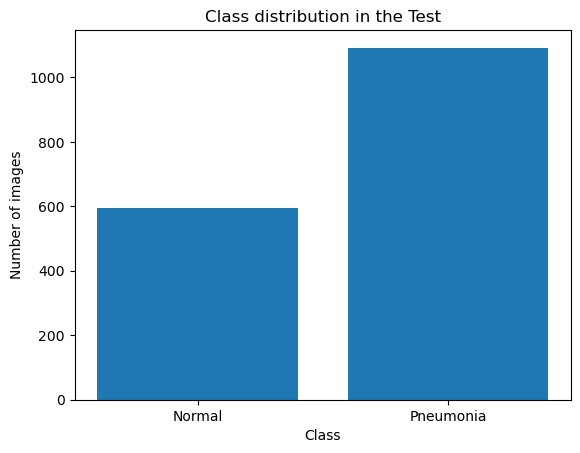

In [28]:
def visualize_class_distribution(data, title):
    nb_classes = np.zeros(len(data.classes))
    # print(nb_classes)
    for _, y in data:
        nb_classes[y] += 1

    print(nb_classes)
    plt.bar(["Normal","Pneumonia"],nb_classes)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Class distribution in the {title}")
    plt.show()


visualize_class_distribution(train_dataset, "Train")
visualize_class_distribution(test_dataset, "Test")

#### Observations
<ul><li>Dataset is imbalanced.
</li><li>Test dataset is about 30% of all the dataset</li></ul>


## Tester un modele hakak brk

In [100]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 56 * 56, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2),
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(3):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
 
    print(f"Epoch [{epoch + 1}]: Train Loss: {running_loss / len(train_loader):.4f}")  

# Evaluate the model on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

Epoch [1]: Train Loss: 5.3470
Epoch [2]: Train Loss: 0.2489
Epoch [3]: Train Loss: 0.2097
Accuracy on the test set: 78.77%


 We got nice accuracy even though we didn't really use a big dataset or many ephocs, but is it really good? let's see

### Confusion matrix

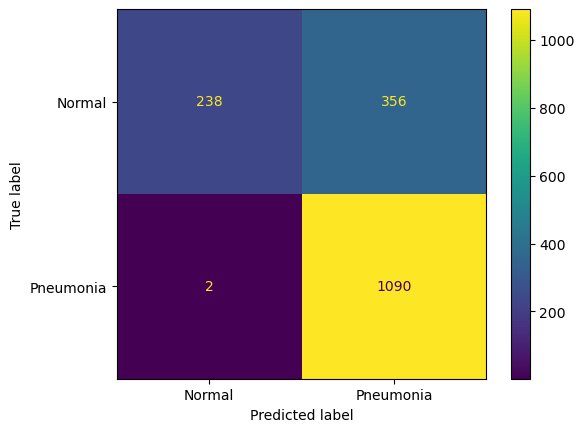

In [101]:
true_labels=[]
predicted_labels=[]
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [102]:
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

Precision: 0.75, Recall: 1.00, F1 score: 0.86


Voila notre modele est overfitted vers Pneumonia qui est la classe dominante , it predicted 257 of (337+257) wrong while for pneumonia it's only predicted 5 wronf out of 1092, so our model is overfitting the pneumonia class 

### Let's improve the model

### As first step: let add more infos (plots,validation set...) to evaluate the model during training

### Adding validation set
On prends une portion de dataset comme une dataset de validation pour qu'on puisse evaluer le model lors de l'entrainement, et assurer bien qu'il est entrain de se generaliser

In [41]:
# Split data into train and validation¶
def extract_patient_ids(filename):
    patient_id = filename.split('_')[0].replace("person", "")
    return patient_id

In [42]:
import os
import random

def split_file_names(input_folder, val_split_perc):
    # Pneumonia files contain patient id, so we group split them by patient to avoid data leakage
    pneumonia_patient_ids = set([extract_patient_ids(fn) for fn in os.listdir(os.path.join(input_folder, 'PNEUMONIA'))])
    pneumonia_val_patient_ids = random.sample(list(pneumonia_patient_ids), int(val_split_perc * len(pneumonia_patient_ids)))

    pneumonia_val_filenames = []
    pneumonia_train_filenames = []

    for filename in os.listdir(os.path.join(input_folder, 'PNEUMONIA')):
        patient_id = extract_patient_ids(filename)
        if patient_id in pneumonia_val_patient_ids:
            pneumonia_val_filenames.append(os.path.join(input_folder, 'PNEUMONIA', filename))
        else:
            pneumonia_train_filenames.append(os.path.join(input_folder, 'PNEUMONIA', filename))

    # Normal (by file, no patient information in file names)
    normal_filenames  = [os.path.join(input_folder, 'NORMAL', fn) for fn in os.listdir(os.path.join(input_folder, 'NORMAL'))]
    normal_val_filenames = random.sample(normal_filenames, int(val_split_perc * len(normal_filenames)))
    normal_train_filenames = list(set(normal_filenames)-set(normal_val_filenames))

    train_filenames = pneumonia_train_filenames + normal_train_filenames
    val_filenames = pneumonia_val_filenames + normal_val_filenames

    return train_filenames, val_filenames

In [44]:
# Define the validation split percentage
val_split = 0.2
train_filenames, val_filenames = split_file_names("train/", val_split)

# Load the datasets
train_dataset = datasets.ImageFolder("train/", transform=data_transforms, is_valid_file=lambda x: x in train_filenames)
val_dataset = datasets.ImageFolder("train/", transform=data_transforms, is_valid_file=lambda x: x in val_filenames)    
test_dataset = datasets.ImageFolder("test/", transform=data_transforms)

# Create the data loaders for train, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)    
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

In [45]:
# calculer loss de validation

In [46]:
def validation_loss(model, val_loader):
    loss_fn = torch.nn.functional.cross_entropy
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

### Adding plots and histories of loss

In [57]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 56 * 56, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_history = []
val_loss_history = []
progress_bar = tqdm(train_loader, desc="Training", leave=False, unit="mini-batch")

# Train the model
model.train()
for epoch in range(3):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    val_loss = validation_loss(model, val_loader)
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
 
    print(f"Epoch [{epoch + 1}]: Train Loss: {running_loss / len(train_loader):.4f}")  

# Evaluate the model on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

Epoch [1]: Train Loss: 0.6399
Epoch [2]: Train Loss: 0.2353
Epoch [3]: Train Loss: 0.1936
Accuracy on the test set: 92.65%


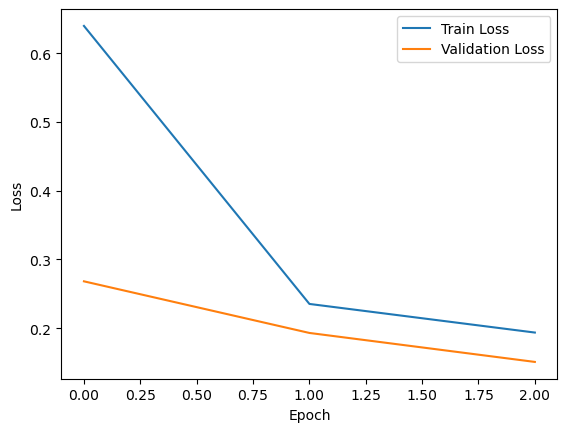

In [58]:
# Plot the learning curve
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Data augmentation

### CNN

In [95]:
model = torch.nn.Sequential(
torch.nn.Conv2d(3, 16, 3, padding=1),
torch.nn.ReLU(),
torch.nn.MaxPool2d(2, 2),
torch.nn.Conv2d(16, 32, 3, padding=1),
torch.nn.ReLU(),
torch.nn.MaxPool2d(2, 2),
torch.nn.Conv2d(32, 64, 3, padding=1),
torch.nn.ReLU(),
torch.nn.MaxPool2d(2, 2),
torch.nn.Flatten(),
torch.nn.Dropout(0.25),
torch.nn.Linear(64 * (56 // 8) * (56 // 8), 512),
torch.nn.ReLU(),
torch.nn.Dropout(0.25),
torch.nn.Linear(512, 64),
torch.nn.ReLU(),
torch.nn.Linear(64, 2)
 )

In [96]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_history = []
val_loss_history = []
# Train the model
model.train()
for epoch in range(5):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    val_loss = validation_loss(model, val_loader)
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
 
    print(f"Epoch [{epoch + 1}]: Train Loss: {running_loss / len(train_loader):.4f}")  

# Evaluate the model on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

Epoch [1]: Train Loss: 0.5038
Epoch [2]: Train Loss: 0.2867
Epoch [3]: Train Loss: 0.1541
Epoch [4]: Train Loss: 0.1250
Epoch [5]: Train Loss: 0.1185
Accuracy on the test set: 92.76%


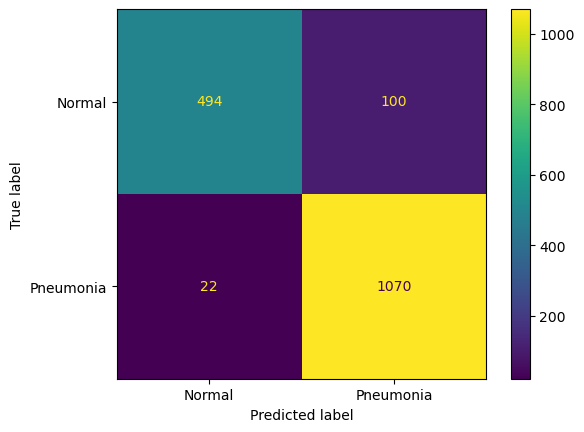

In [98]:
true_labels=[]
predicted_labels=[]
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [99]:
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

Precision: 0.91, Recall: 0.98, F1 score: 0.95


## VGG

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define the VGG model
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, 2)  # Change the last fully connected layer for binary classification

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_history = []
val_loss_history = []

# Train the model
model.train()
for epoch in range(3):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    val_loss = validation_loss(model, val_loader)
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
 
    print(f"Epoch [{epoch + 1}]: Train Loss: {train_loss:.4f}")  

# Evaluate the model on the test set
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / total:.2%}")


C:\Users\aorus\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aorus\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1]: Train Loss: 3.8216
Epoch [2]: Train Loss: 0.5622
Epoch [3]: Train Loss: 0.5737
Accuracy on the test set: 64.77%


## RESNET

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define the ResNet model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 2)  # Change the last fully connected layer for binary classification

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_history = []
val_loss_history = []

# Train the model
model.train()
for epoch in range(3):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    val_loss = validation_loss(model, val_loader)
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
 
    print(f"Epoch [{epoch + 1}]: Train Loss: {train_loss:.4f}")  

# Evaluate the model on the test set
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / total:.2%}")


Epoch [1]: Train Loss: 0.1879
Epoch [2]: Train Loss: 0.7955
Epoch [3]: Train Loss: 0.3956
Accuracy on the test set: 88.43%
